In [38]:
# !pip install nltk
# !pip install tensorflow
# !pip install WordCloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 KB 1.3 MB/s eta 0:00:00a 0:00:01


In [62]:
# import dependencies
import pandas as pd
import numpy as np
import csv

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')


In [6]:
fake_news_df = pd.read_csv("fake_news.csv")
display(fake_news_df)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [7]:
# check missing values in dataset
fake_news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
# replace NaN values in 'title' and 'text' with 'missing'
fake_news_df['title'].fillna("", inplace=True)
fake_news_df['text'].fillna("", inplace=True)

In [9]:
# combine 'title' and 'text' into a one single variable
fake_news_df['content'] = fake_news_df['title'] + ' ' + fake_news_df['text']
fake_news_df.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [10]:
# drop unnecessary column
fake_news_df.drop(["id", "author"],axis=1,inplace=True)

# Class Imbalance check

1    10413
0    10387
Name: label, dtype: int64


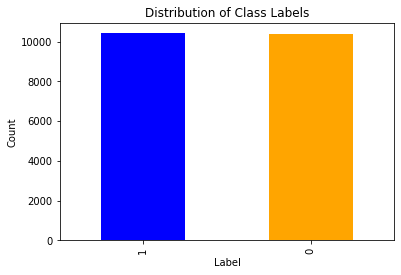

In [11]:
# check the distribution of the class labels
label_count = fake_news_df["label"].value_counts()
print(label_count)

label_count.plot(kind='bar', color=['blue','orange'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

## EDA Processing 

### Text Length Distribution by Label


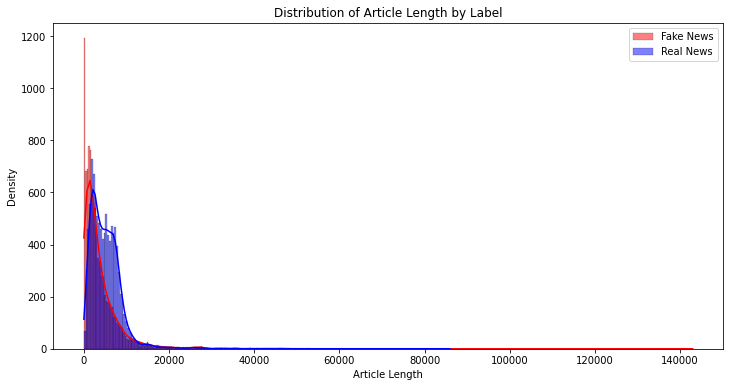

In [46]:
fake_news_df['total_length'] = fake_news_df['text'].apply(len)

# create separate dataframes for fake and real news
fake_news = fake_news_df[fake_news_df['label']==1]
real_news = fake_news_df[fake_news_df['label']==0]

# plot the distribution of article length for each label
plt.figure(figsize=(12,6))
sns.histplot(fake_news['total_length'], color='red', kde=True, label='Fake News')
sns.histplot(real_news['total_length'], color='blue', kde=True, label='Real News')
plt.title('Distribution of Article Length by Label')
plt.xlabel('Article Length')
plt.ylabel('Density')
plt.legend()
plt.show()

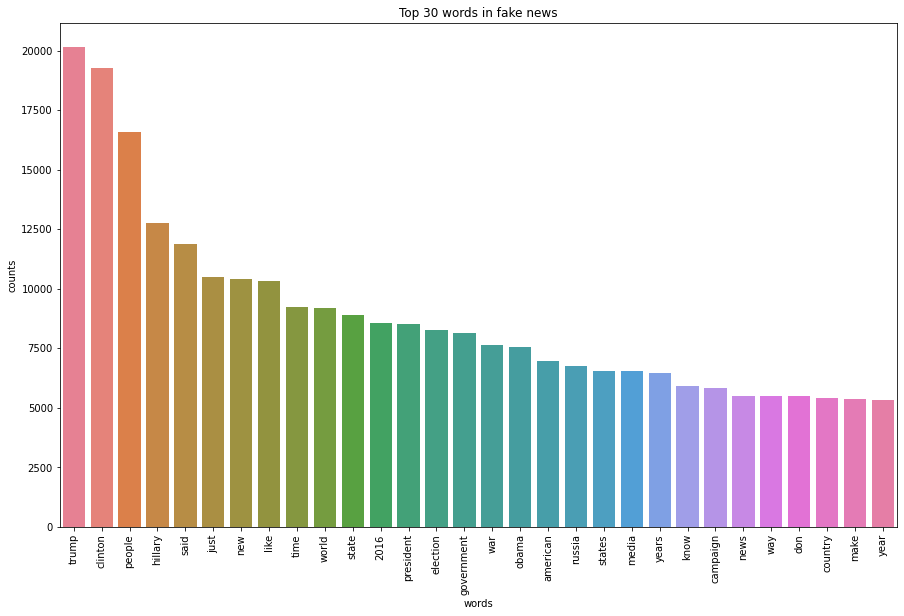

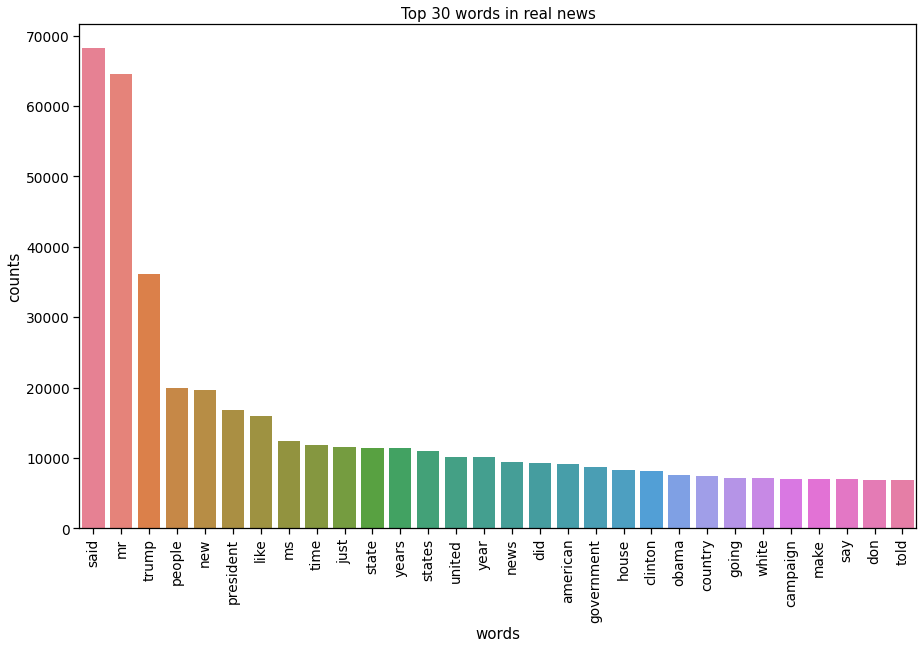

In [49]:
# bar Plot of the Most Frequent Words
def plot_top_n_words(n, text, title):
    count_vectorizer = CountVectorizer(stop_words='english')
    count_data = count_vectorizer.fit_transform(text)

    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))

    for t in count_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=words, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# separate text data for 'fake' and 'real' news
fake_text = fake_news_df[fake_news_df['label']==1]['text']
real_text = fake_news_df[fake_news_df['label']==0]['text']

# plot top n words for 'fake' and 'real' news
plot_top_n_words(30, fake_text, 'Top 30 words in fake news')
plot_top_n_words(30, real_text, 'Top 30 words in real news')

## Bigrams Analysis


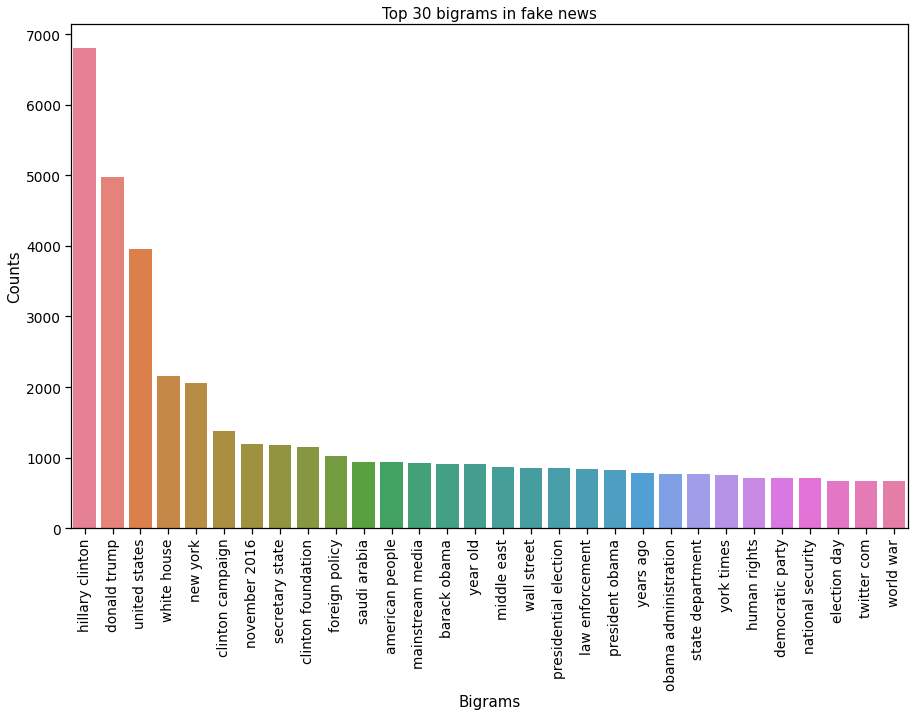

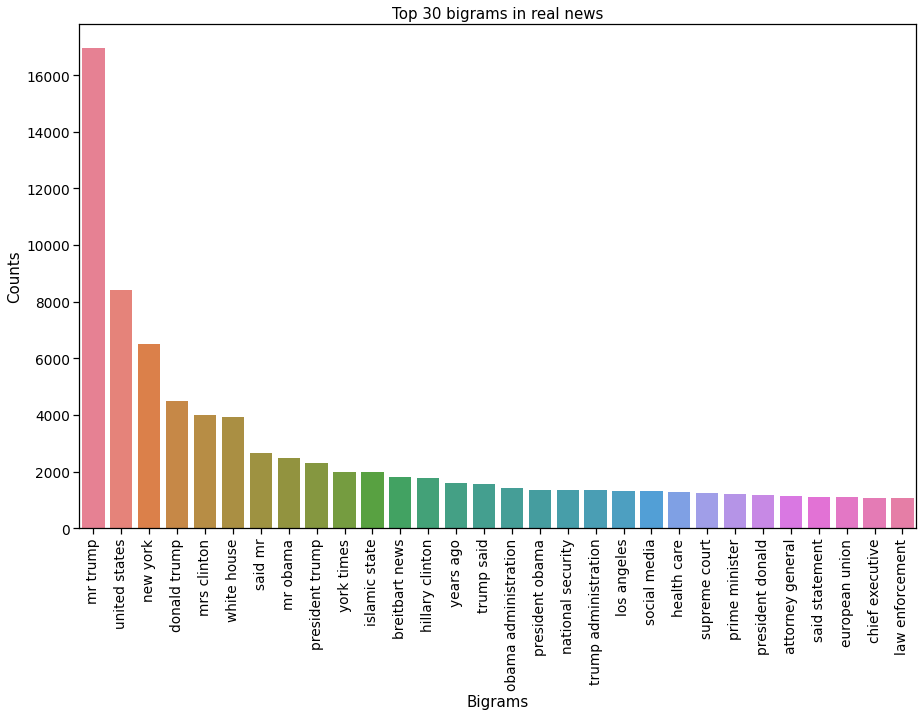

In [51]:
# Function to plot top n bigrams
def plot_top_n_bigrams(n, text, title):
    count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
    count_data = count_vectorizer.fit_transform(text)

    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))

    for t in count_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=words, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('Bigrams')
    plt.ylabel('Counts')
    plt.show()

# Plot top n bigrams for fake and real news
plot_top_n_bigrams(30, fake_news['text'], 'Top 30 bigrams in fake news')
plot_top_n_bigrams(30, real_news['text'], 'Top 30 bigrams in real news')


## TF-IDF Analysis


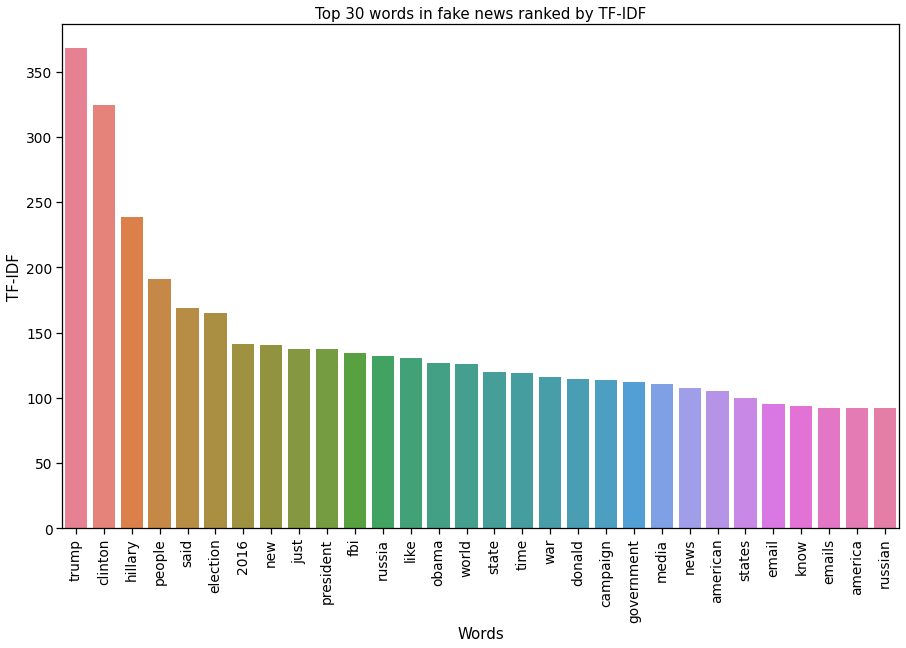

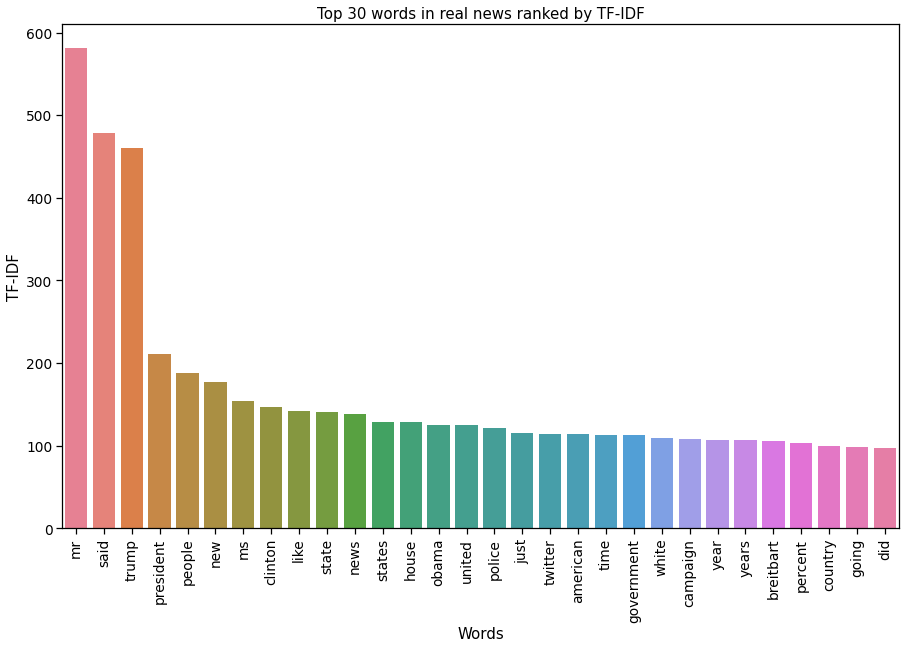

In [54]:
# Function to calculate and plot top n words ranked by TF-IDF
def plot_top_n_tfidf(n, text, title):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_data = tfidf_vectorizer.fit_transform(text)

    words = tfidf_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))

    for t in tfidf_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=words, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('Words')
    plt.ylabel('TF-IDF')
    plt.show()

# Plot top n words ranked by TF-IDF for fake and real news
plot_top_n_tfidf(30, fake_news['text'], 'Top 30 words in fake news ranked by TF-IDF')
plot_top_n_tfidf(30, real_news['text'], 'Top 30 words in real news ranked by TF-IDF')

# Data pre-processing

In [12]:
#insignificant words
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruddysimonpour/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
from nltk.stem import PorterStemmer

port_stem = PorterStemmer()

def remove_non_alpha(text):
    # remove numbers and punctuation, keep only alphabets
    return re.sub('[^a-zA-Z]+', ' ', text)

def lowercase(text):
    # convert all alphabets into lowercase
    return text.lower()

def remove_stopwords_and_stem(text):
    # split and convert to list
    words = text.split()

    # stem all the words that are not in stopwords
    stemmed_words = [port_stem.stem(word) for word in words if word not in stopwords.words('english')]

    # join the stemmed words back into a string
    return ' '.join(stemmed_words)

def clean_text(content):
    cleaned_content = remove_non_alpha(content)
    cleaned_content = lowercase(cleaned_content)
    cleaned_content = remove_stopwords_and_stem(cleaned_content)
    return cleaned_content

In [14]:
# Apply the preprocessing to the 'content' colum
fake_news_df['content'] = fake_news_df['content'].apply(clean_text)

# Data Partitioning

In [15]:
# data splitting
train_X, test_X, train_y, test_y = train_test_split(fake_news_df['content'], fake_news_df['label'],
                                                    test_size=0.2, random_state = 42, stratify=fake_news_df['label'])


# Text Tokenizer

In [16]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")

tokenizer.fit_on_texts(train_X)

# tokenize the training and test data
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_length = int(np.percentile([len(seq) for seq in train_sequences], 95))

# padding the sequences
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

# Modeling

## Deep Learning Models

### Running LSTM Network

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

LSTM_model = Sequential()

LSTM_model.add(Embedding(input_dim=20000, output_dim=128, input_length=max_length))

# LSTM layer
LSTM_model.add(LSTM(128))

LSTM_model.add(Dense(1, activation='sigmoid'))

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1037, 128)         2560000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2691713 (10.27 MB)
Trainable params: 2691713 (10.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
history_LSTM = LSTM_model.fit(train_padded, train_y, epochs=10, validation_data=(test_padded, test_y))

Epoch 1/10
520/520 [==============================] - 535s 1s/step - loss: 0.6911 - accuracy: 0.5109 - val_loss: 0.6888 - val_accuracy: 0.5192
Epoch 2/10
520/520 [==============================] - 525s 1s/step - loss: 0.6716 - accuracy: 0.5213 - val_loss: 0.6776 - val_accuracy: 0.5224
Epoch 3/10
520/520 [==============================] - 517s 995ms/step - loss: 0.6631 - accuracy: 0.5271 - val_loss: 0.6827 - val_accuracy: 0.5226
Epoch 4/10
520/520 [==============================] - 507s 974ms/step - loss: 0.6093 - accuracy: 0.6483 - val_loss: 0.6953 - val_accuracy: 0.5649
Epoch 5/10
520/520 [==============================] - 713s 1s/step - loss: 0.5817 - accuracy: 0.7082 - val_loss: 0.6028 - val_accuracy: 0.7151
Epoch 6/10
520/520 [==============================] - 773s 1s/step - loss: 0.5746 - accuracy: 0.7194 - val_loss: 0.6045 - val_accuracy: 0.7082
Epoch 7/10
520/520 [==============================] - 697s 1s/step - loss: 0.5849 - accuracy: 0.6994 - val_loss: 0.6130 - val_accuracy: 

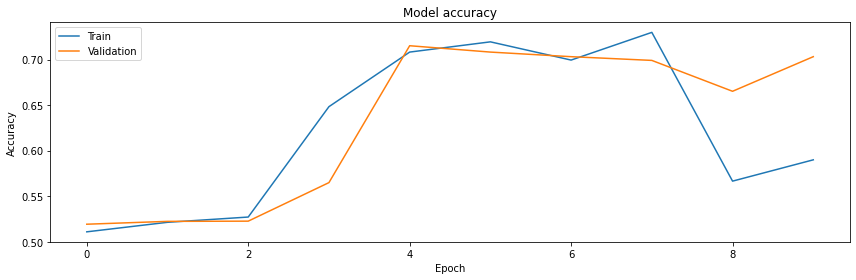

In [21]:
plt.figure(figsize=(12, 4))

plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

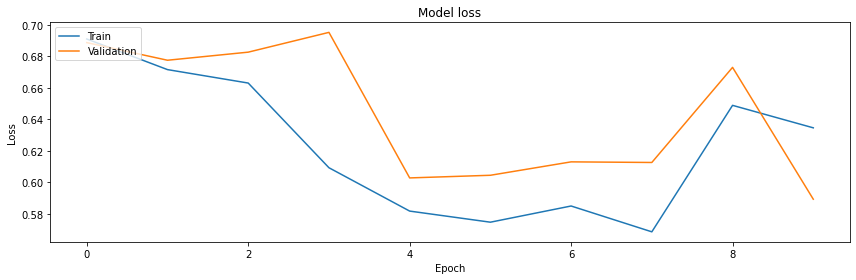

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [97]:
# model evaluation test dataset
def model_evaluation(model,X_test,y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    #print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    return score

In [94]:
model_evaluation(LSTM_model,test_padded, test_y)

Test loss: 0.5892598628997803 / Test accuracy: 0.703125


0.5892598628997803

### Running RNN Network

In [26]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

RNN_model = Sequential()

RNN_model.add(Embedding(input_dim=20000, output_dim=128, input_length=max_length))

# SimpleRNN layer
RNN_model.add(SimpleRNN(128))

RNN_model.add(Dense(1, activation='sigmoid'))

RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

RNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1037, 128)         2560000   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2593025 (9.89 MB)
Trainable params: 2593025 (9.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
history_RNN = RNN_model.fit(train_padded, train_y, epochs=10, validation_data=(test_padded, test_y))

Epoch 1/10
520/520 [==============================] - 186s 342ms/step - loss: 0.6969 - accuracy: 0.5023 - val_loss: 0.6948 - val_accuracy: 0.5120
Epoch 2/10
520/520 [==============================] - 174s 335ms/step - loss: 0.6954 - accuracy: 0.5135 - val_loss: 0.6908 - val_accuracy: 0.5267
Epoch 3/10
520/520 [==============================] - 177s 340ms/step - loss: 0.6944 - accuracy: 0.5219 - val_loss: 0.6905 - val_accuracy: 0.5255
Epoch 4/10
520/520 [==============================] - 172s 330ms/step - loss: 0.6906 - accuracy: 0.5304 - val_loss: 0.6953 - val_accuracy: 0.5065
Epoch 5/10
520/520 [==============================] - 166s 319ms/step - loss: 0.6874 - accuracy: 0.5320 - val_loss: 0.6889 - val_accuracy: 0.5296
Epoch 6/10
520/520 [==============================] - 171s 328ms/step - loss: 0.6819 - accuracy: 0.5418 - val_loss: 0.6859 - val_accuracy: 0.5305
Epoch 7/10
520/520 [==============================] - 204s 393ms/step - loss: 0.6782 - accuracy: 0.5411 - val_loss: 0.6866 -

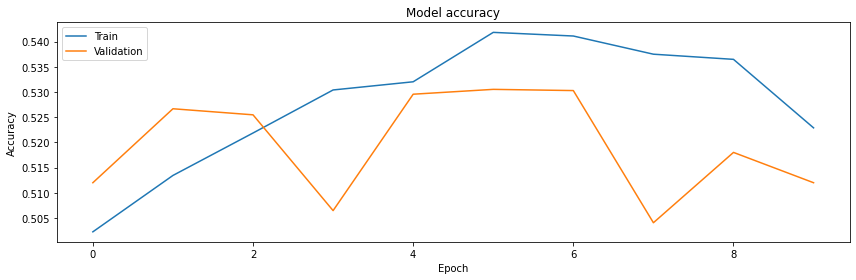

In [28]:
plt.figure(figsize=(12, 4))

plt.plot(history_RNN.history['accuracy'])
plt.plot(history_RNN.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

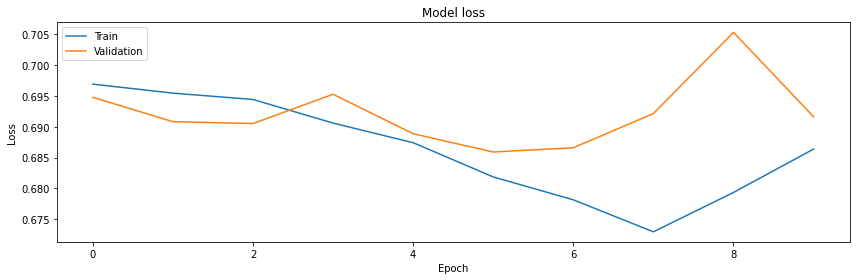

In [29]:
plt.figure(figsize=(12, 4))
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [34]:
model_evaluation(RNN_model,test_padded, test_y)

Test loss: 0.691611647605896 / Test accuracy: 0.5120192170143127


[0.691611647605896, 0.5120192170143127]

### Running GRU Network 

In [30]:
from tensorflow.keras.layers import Embedding, GRU, Dense

GRU_model = Sequential()

GRU_model.add(Embedding(input_dim=20000, output_dim=128, input_length=max_length))

# GRU layer
GRU_model.add(GRU(128))

GRU_model.add(Dense(1, activation='sigmoid'))

GRU_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

GRU_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1037, 128)         2560000   
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2659201 (10.14 MB)
Trainable params: 2659201 (10.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
history_GRU = GRU_model.fit(train_padded, train_y, epochs=10, validation_data=(test_padded, test_y))

Epoch 1/10
520/520 [==============================] - 392s 747ms/step - loss: 0.6905 - accuracy: 0.5087 - val_loss: 0.6869 - val_accuracy: 0.5043
Epoch 2/10
520/520 [==============================] - 441s 848ms/step - loss: 0.6809 - accuracy: 0.5257 - val_loss: 0.6856 - val_accuracy: 0.5190
Epoch 3/10
520/520 [==============================] - 355s 683ms/step - loss: 0.6680 - accuracy: 0.5239 - val_loss: 0.6842 - val_accuracy: 0.5192
Epoch 4/10
520/520 [==============================] - 364s 701ms/step - loss: 0.6633 - accuracy: 0.5244 - val_loss: 0.6868 - val_accuracy: 0.5183
Epoch 5/10
520/520 [==============================] - 386s 742ms/step - loss: 0.6618 - accuracy: 0.5256 - val_loss: 0.6889 - val_accuracy: 0.5175
Epoch 6/10
520/520 [==============================] - 369s 709ms/step - loss: 0.6608 - accuracy: 0.5243 - val_loss: 0.6915 - val_accuracy: 0.5175
Epoch 7/10
520/520 [==============================] - 421s 810ms/step - loss: 0.6599 - accuracy: 0.5295 - val_loss: 0.6925 -

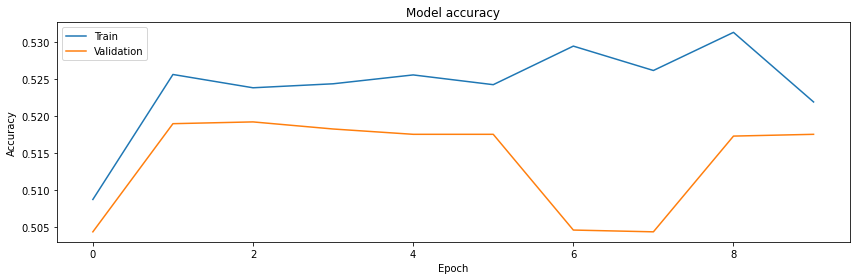

In [32]:
plt.figure(figsize=(12, 4))

plt.plot(history_GRU.history['accuracy'])
plt.plot(history_GRU.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

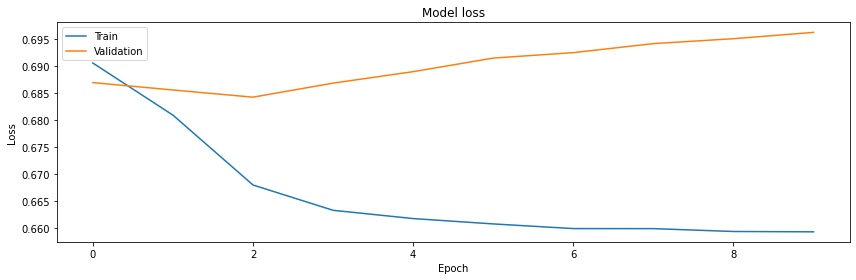

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
model_evaluation(GRU_model,test_padded, test_y)

Test loss: 0.6962171792984009 / Test accuracy: 0.5175480842590332


[0.6962171792984009, 0.5175480842590332]

## Classical Algorithms

In [55]:
# transform the text data using TF-IDF
vectorizer = TfidfVectorizer()
train_X = vectorizer.fit_transform(train_X)
test_X = vectorizer.transform(test_X)

In [89]:
print("Shape of train_X: ", train_X.shape)
print("Shape of test_X: ", test_X.shape)

Shape of train_X:  (16640, 98702)
Shape of test_X:  (4160, 98702)


### Logistic Regression

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Hyperparameter Tuning for Logistic Regression Using RandomizedSearchCV

In [63]:
# Hyperparameters to tune
param_dict = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': list(range(100,800,100))
}

random_search = RandomizedSearchCV(LogisticRegression(), 
                                   param_distributions=param_dict,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=5, 
                                   n_jobs=-1)

random_search.fit(train_X, train_y)

# best parameters
best_parameters = random_search.best_params_
print("Best Parameters:", best_parameters)

# best parameter to fit the model
lr_model = LogisticRegression(**best_parameters)
lr_model.fit(train_X, train_y)

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

Best Parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 300, 'C': 10}


LogisticRegression(C=10, max_iter=300, penalty='l1', solver='saga')

In [93]:
# prediction
lr_prediction_train = lr_model.predict(train_X)
lr_prediction_test = lr_model.predict(test_X)

# Evaluate the model
print("Train Accuracy: ", accuracy_score(train_y, lr_prediction_train))

print("Test Accuracy: ", accuracy_score(test_y, lr_prediction_test))
print("Confusion Matrix: \n", confusion_matrix(test_y, lr_prediction_test))
print("Classification Report: \n", classification_report(test_y, lr_prediction_test))

Train Accuracy:  0.9993990384615384
Test Accuracy:  0.9627403846153846
Confusion Matrix: 
 [[1999   78]
 [  77 2006]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2077
           1       0.96      0.96      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



### Decision Tree

In [67]:
from sklearn.tree import DecisionTreeClassifier

### Hyperparameter Tuning for Decision Tree Using RandomizedSearchCV

In [72]:
# Hyperparameters to tune
param_dict = {"max_depth": range(1,10),
              "min_samples_split": range(2,10),
              "min_samples_leaf": range(1,5),
              "criterion": ['gini', 'entropy']}

random_search = RandomizedSearchCV(DecisionTreeClassifier(), 
                                   param_distributions=param_dict, 
                                   cv=5, 
                                   scoring='accuracy', 
                                   n_iter=50, 
                                   random_state=42)

random_search.fit(train_X, train_y)

# best parameters
best_parameters = random_search.best_params_
print("Best Parameters:", best_parameters)

# best parameter to fit the model
dtree_model = DecisionTreeClassifier(**best_parameters)
dtree_model.fit(train_X, train_y)

Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 9, 'criterion': 'gini'}


DecisionTreeClassifier(max_depth=9, min_samples_split=5)

In [102]:
# prediction
dt_prediction_train = dtree_model.predict(train_X)
dt_prediction_test = dtree_model.predict(test_X)

# Evaluate the model
print("Train Accuracy: ", accuracy_score(train_y, dt_predictions_train))

print("Test Accuracy: ", accuracy_score(test_y, dt_predictions_test))
print("Confusion Matrix: \n", confusion_matrix(test_y, dt_predictions_test))
print("Classification Report: \n", classification_report(test_y, dt_predictions_test))

Train Accuracy:  0.9576923076923077
Test Accuracy:  0.9350961538461539
Confusion Matrix: 
 [[1919  158]
 [ 112 1971]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      2077
           1       0.93      0.95      0.94      2083

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



### Support Vector Machine ( Linear Kernel )

In [82]:
from sklearn.svm import LinearSVC

### Hyperparameter Tuning for Supprot Vector Machine Using RandomizedSearchCV

In [85]:
# Set up the parameter distribution
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

svc = LinearSVC()

random_search = RandomizedSearchCV(svc, 
                                   param_grid,
                                   n_iter=5,
                                   cv=5, 
                                   random_state=42)


random_search.fit(train_X, train_y)

best_params= random_search.best_params_

print(f"Best parameters: {best_params}")

svc_model = LinearSVC(C=best_params["C"])
svc_model.fit(train_X, train_y)

Best parameters: {'C': 10}


LinearSVC(C=10)

In [103]:
# Prediction
svc_prediction_train = svc_model.predict(train_X)
svc_prediction_test = svc_model.predict(test_X)

# Evaluate the model
print("Train Accuracy: ", accuracy_score(train_y, svc_predictions_train))

print("Test Accuracy: ", accuracy_score(test_y, svc_predictions_test))
print("Confusion Matrix: \n", confusion_matrix(test_y, svc_predictions_test))
print("Classification Report: \n", classification_report(test_y, svc_predictions_test))

Train Accuracy:  1.0
Test Accuracy:  0.9610576923076923
Confusion Matrix: 
 [[2001   76]
 [  86 1997]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2077
           1       0.96      0.96      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



## Evaluation

In [105]:
########################## TRAIN ACCURACY
# Deep Learning algorithms
LSTM_train_accuracy = model_evaluation(LSTM_model, train_padded, train_y)[1] # LSTM
RNN_train_accuracy = model_evaluation(RNN_model, train_padded, train_y)[1] # RNN
GRU_train_accuracy = model_evaluation(GRU_model, train_padded, train_y)[1] # GRU

# Classical algorithms
LR_train_accuracy = accuracy_score(train_y, lr_prediction_train) # Logistic Regression
DT_train_accuracy = accuracy_score(train_y, dt_prediction_train) # Decision Tree 
SVC_train_accuracy = accuracy_score(train_y, svc_prediction_train) # Support Vector Machine 


########################## TEST ACCURACY
# Deep Learning algorithms
LSTM_test_accuracy = model_evaluation(LSTM_model, test_padded, test_y)[1] # LSTM
RNN_test_accuracy = model_evaluation(RNN_model, test_padded, test_y)[1] # RNN
GRU_test_accuracy = model_evaluation(GRU_model, test_padded, test_y)[1] # GRU

# Classical algorithms
LR_test_accuracy = accuracy_score(test_y, lr_prediction_test) # Logistic Regression
DT_test_accuracy = accuracy_score(test_y, dt_prediction_test) # Decision Tree 
SVC_test_accuracy = accuracy_score(test_y, svc_prediction_test) # Support Vector Machine 

In [107]:
data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'LSTM', 'RNN', 'GRU'],
    'Train Accuracy': [LR_train_accuracy, DT_train_accuracy, SVC_train_accuracy, LSTM_train_accuracy, RNN_train_accuracy, GRU_train_accuracy],
    'Test Accuracy': [LR_test_accuracy, DT_test_accuracy, SVC_test_accuracy, LSTM_test_accuracy, RNN_test_accuracy, GRU_test_accuracy]
}

accuracy_df = pd.DataFrame(data)
accuracy_df


,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.999399,0.962740
1,Decision Tree,0.957692,0.935096
2,Support Vector Machine,1.000000,0.961058
3,LSTM,0.712680,0.703125
4,RNN,0.527704,0.512019
5,GRU,0.526923,0.517548


The first thing to note is that for the classical models, the training accuracies are nearly perfect. Logistic Regression and Support Vector Machines both have training accuracies of nearly 1.0, suggesting that they have learned the training data very well. This might indicate some overfitting, since a model that perfectly learns the training data might not generalize well to unseen data. However, this doesn't appear to be a significant problem here, as the test accuracies are also quite high.

For the deep learning models, the training and test accuracies are significantly lower. This might be due to a variety of factors. For one, deep learning models often require a large amount of data to train effectively, and depending on the size and complexity of your dataset, it might not be enough. Additionally, deep learning models can be more sensitive to the choice of hyperparameters, such as the learning rate, the number of layers in the model, and the number of nodes in each layer. If these aren't set appropriately, the model might not learn effectively.

The relatively close train and test accuracies for the deep learning models suggest that overfitting is not a significant issue for these models - rather, they seem to be underfitting, as they're performing similarly on both the training and test sets. Overfitting typically occurs when a model learns the training data too well, to the point where it performs poorly on the test data. Underfitting, on the other hand, happens when a model doesn't learn the training data well enough, and as a result performs poorly on both the training and test data.

One possible solution could be to adjust the architecture of our deep learning models or the training procedure (like the number of epochs, the batch size, etc.). More complex models (more layers or nodes) might be able to capture more intricate patterns in the data. However, increasing model complexity also increases the risk of overfitting, so it's a bit of a balancing act.

Alternatively, we can also try different types of models or even a combination of models (an ensemble). For example, Convolutional Neural Networks (CNNs) can sometimes perform well on text classification tasks, especially when the spatial structure in the data is important. Similarly, transformer-based models (like BERT) have been very successful for a variety of text classification tasks.

In [110]:
from sklearn.metrics import roc_auc_score

lr_probs = lr_model.predict_proba(test_X)[:, 1]
dt_probs = dtree_model.predict_proba(test_X)[:, 1]
svc_probs = svc_model.decision_function(test_X)
lstm_probs = LSTM_model.predict(test_padded)
rnn_probs = RNN_model.predict(test_padded)
gru_probs = GRU_model.predict(test_padded)

# Compute the ROC AUC values
LR_AUC = roc_auc_score(test_y, lr_probs)
DT_AUC = roc_auc_score(test_y, dt_probs)
SVC_AUC = roc_auc_score(test_y, svc_probs)
LSTM_AUC = roc_auc_score(test_y, lstm_probs)
RNN_AUC = roc_auc_score(test_y, rnn_probs)
GRU_AUC = roc_auc_score(test_y, gru_probs)

data['AUC'] = [LR_AUC, DT_AUC, SVC_AUC, LSTM_AUC, RNN_AUC, GRU_AUC]

# Create the DataFrame
accuracy_df = pd.DataFrame(data)
accuracy_df


,Model,Train Accuracy,Test Accuracy,AUC
0,Logistic Regression,0.999399,0.962740,0.993047
1,Decision Tree,0.957692,0.935096,0.953203
2,Support Vector Machine,1.000000,0.961058,0.992718
3,LSTM,0.712680,0.703125,0.750907
4,RNN,0.527704,0.512019,0.523403
5,GRU,0.526923,0.517548,0.557668


## AUC/ROC Curve of Classical Machine Learning Algorithms

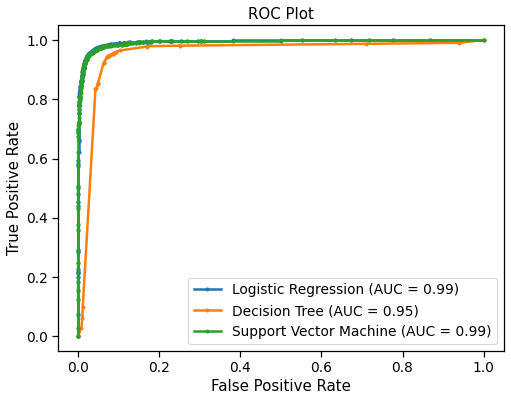

In [111]:
from sklearn.metrics import roc_curve

lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
dt_fpr, dt_tpr, _ = roc_curve(test_y, dt_probs)
svc_fpr, svc_tpr, _ = roc_curve(test_y, svc_probs)

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression (AUC = %0.2f)' % LR_AUC)
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree (AUC = %0.2f)' % DT_AUC)
plt.plot(svc_fpr, svc_tpr, marker='.', label='Support Vector Machine (AUC = %0.2f)' % SVC_AUC)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()


## AUC/ROC Curve of Deep Learning Algorithms

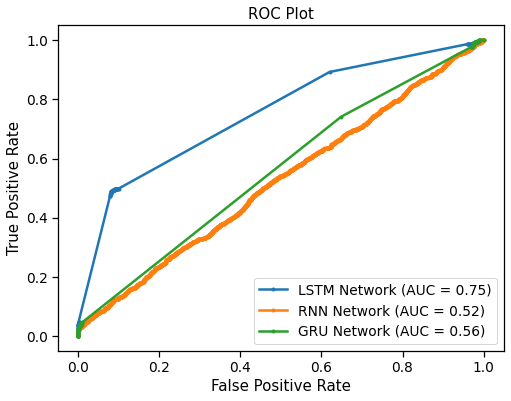

In [112]:
lstm_fpr, lstm_tpr, _ = roc_curve(test_y, lstm_probs)
rnn_fpr, rnn_tpr, _ = roc_curve(test_y, rnn_probs)
gru_fpr, gru_tpr, _ = roc_curve(test_y, gru_probs)

plt.figure(figsize=(8, 6))
plt.plot(lstm_fpr, lstm_tpr, marker='.', label='LSTM Network (AUC = %0.2f)' % LSTM_AUC)
plt.plot(rnn_fpr, rnn_tpr, marker='.', label='RNN Network (AUC = %0.2f)' % RNN_AUC)
plt.plot(gru_fpr, gru_tpr, marker='.', label='GRU Network (AUC = %0.2f)' % GRU_AUC)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()
